In [ ]:
import numpy as np
import scipy.signal as spsig
import scipy.interpolate as sinterp
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import PIL
import time
from tqdm.notebook import tqdm

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [ ]:
plt.rcParams['figure.figsize'] = (16, 8)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')



In [ ]:
#@title SimPSFToolkit definition

class SimPSFToolkit(object):
    """Simulate PSFs.
    
    In the future the zernike maps could be created with galsim.
    
    Parameters
    ----------
    zernike_maps
    pad_factor=2
    max_order=45
    max_wfe: float
        Maximum allowed WFE at ``lambda_norm``. Used for
        normalization. Units in [\mu m].
        Default is ``0.1``.
    lambda_norm: float
        Corresponds to the wavelength at which the normalization 
        of the WFE is taking place. Units in [\mu m].
        Default is ``0.550``.
    rand_seed=None
    plot_opt=True
    
    """
    
    def __init__(self, zernike_maps, max_order=45, max_wfe_rms=0.1,
                 output_dim=64, rand_seed=None, plot_opt=False, oversampling_rate=2,
                 pix_sampling=12, tel_diameter=1.2, tel_focal_length=24.5,
                 pupil_diameter=1024, euclid_obsc=True, LP_filter_length=3, verbose=0):
        # Input attributes
        self.max_order = max_order
        self.rand_seed = rand_seed
        self.plot_opt = plot_opt
        self.zernike_maps = zernike_maps
        self.max_wfe_rms = max_wfe_rms  # In [um]
        self.output_dim = output_dim  # In pixels per dimension
        self.verbose = verbose
        
        
        # Telescope characteristics
        self.oversampling_rate = oversampling_rate  # dimensionless
        self.pix_sampling = pix_sampling  # In [um]
        self.tel_diameter = tel_diameter  # In [m]
        self.tel_focal_length = tel_focal_length  # In [m]
        self.pupil_diameter = pupil_diameter  # In [pix]
        
        # Class attributes
        self.z_coeffs = None
        self.psf = None
        self.opd = None
        self.phase = None
        self.lambda_obs = None
        self.poly_psf = None
        
        # Generate pupil mask
        self.pupil_mask = ~np.isnan(self.zernike_maps[0])
        
        # Generate obscurations
        if euclid_obsc:
            self.obscurations = self.generate_pupil_obscurations(N_pix=pupil_diameter, N_filter=LP_filter_length)
        else:
            self.obscurations = np.ones((pupil_diameter, pupil_diameter))    
        
        
    @staticmethod
    def _OLD_fft_diffraction_op(wf, pupil_mask, pad_factor=2, match_shapes=True):
        """ Perform a fft-based diffraction.

        Parameters
        ----------
        wf: np.ndarray
            A complex 2D array that corresponds to the wavefront function.
        pupil_mask: np.ndarray of bools
            A 2D boolean mask that corresponds to the pupil function.


        Returns
        -------
        psf: np.ndarray
            A real 2D array corresponding to the PSF.

        """
        start = (wf.shape[0]*pad_factor)//2 - wf.shape[0]//2
        stop = (wf.shape[0]*pad_factor)//2 + wf.shape[0]//2

        padded_wf = np.zeros((wf.shape[0]*pad_factor, wf.shape[1]*pad_factor), dtype=np.complex128)

        padded_wf[start:stop, start:stop][pupil_mask] = wf[pupil_mask]

        fft_wf = np.fft.fftshift(np.fft.fft2(padded_wf))
        # fft_wf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(padded_wf)))
        
        psf = np.abs(fft_wf)**2
        
        if match_shapes:
            # Return the psf with its original shape without the padding factor
            x_dif = int((psf.shape[0]/pad_factor)//2)
            y_dif = int((psf.shape[1]/pad_factor)//2)        

            return psf[x_dif :psf.shape[0]-x_dif, y_dif :psf.shape[1]-y_dif]
        else:
            return psf
    
    
    @staticmethod
    def fft_diffract(wf, output_dim=64):
        # Perform the FFT-based diffraction operation
        fft_wf = np.fft.fftshift(np.fft.fft2(wf))
        psf = np.abs(fft_wf)**2
        
        # Crop the image
        start = int(psf.shape[0]//2-output_dim//2)
        stop = int(psf.shape[0]//2+output_dim//2)        

        return psf[start:stop, start:stop]

    @staticmethod
    def generate_pupil_obscurations(N_pix=1024, N_filter=3):
        """Generate Euclid like pupil obscurations.

        Simple procedure considering only the 2D plane.
        No 3D projections wrt the angle of the FoV is done.

        Parameters
        ----------
        N_pix: int
            Total number of pixels
        N_filter: int
            Length of the low-pass filter [pixels]

        """
        # Telescope parameters
        AS_diam = 1200  # Aperture stop diameter [mm]
        M1_diam = 395  # Mirror 1 cap stopper diameter [mm]

        sp_lenght = 700  # Spider length [mm]
        sp_width = 12  # Spider width [mm] 

        AS_centre = [0, 0]
        M1_centre = [0, 51]

        sp1_angle = 106.78 - 90 # [degrees]
        sp2_angle = 50.11 - 90 # [degrees]
        sp3_angle = -10.76 - 90 # [degrees]

        sp1_x_pos = 260  # [mm]
        sp1_y_pos = 240  # [mm]
        sp2_x_pos = -330  # [mm]
        sp2_y_pos = 130  # [mm]
        sp3_x_pos = 70  # [mm]
        sp3_y_pos = -330  # [mm]


        # Build pupil plane
        pupil_plane = np.ones((N_pix, N_pix))

        # coordinates of map in [mm]
        W, H  = np.meshgrid(np.linspace(-AS_diam//2, AS_diam//2, N_pix), np.linspace(-AS_diam//2, AS_diam//2, N_pix)) 


        ### Calculate the Aperture stop and draw it ###
        aperture_stop_mask = np.sqrt((W - AS_centre[0])**2 + (H - AS_centre[1])**2) <= (AS_diam/2) 
        pupil_plane[~aperture_stop_mask] = 0


        ### Calculate the M1/M2 obscurations and draw them ###
        M1_mask = np.sqrt((W - M1_centre[0])**2 + (H - M1_centre[1])**2) <= (M1_diam/2)
        pupil_plane[M1_mask] = 0


        ### Calculate the spiders and draw them ###

        # Spider 1
        sp1_a = np.tan(sp1_angle*(np.pi/180))
        sp1_b = sp1_y_pos - sp1_a*sp1_x_pos

        sp1_mask_1 = sp1_a*W + sp1_b - sp_width/2 * np.sqrt(1 + sp1_a**2) < H
        sp1_mask_2 = sp1_a*W + sp1_b + sp_width/2 * np.sqrt(1 + sp1_a**2) > H
        sp1_mask = np.logical_and(sp1_mask_1, sp1_mask_2)

        sp1_length_mask = np.sqrt((W - sp1_x_pos)**2 + (H - sp1_y_pos)**2) <= (sp_lenght/2)
        sp1_mask = np.logical_and(sp1_mask, sp1_length_mask)

        # Spider 2
        sp2_a = np.tan(sp2_angle*(np.pi/180))
        sp2_b = sp2_y_pos - sp2_a*sp2_x_pos

        sp2_mask_1 = sp2_a*W + sp2_b - sp_width/2 * np.sqrt(1 + sp2_a**2) < H
        sp2_mask_2 = sp2_a*W + sp2_b + sp_width/2 * np.sqrt(1 + sp2_a**2) > H
        sp2_mask = np.logical_and(sp2_mask_1, sp2_mask_2)

        sp2_length_mask = np.sqrt((W - sp2_x_pos)**2 + (H - sp2_y_pos)**2) <= (sp_lenght/2)
        sp2_mask = np.logical_and(sp2_mask, sp2_length_mask)

        # Spider 3
        sp3_a = np.tan(sp3_angle*(np.pi/180))
        sp3_b = sp3_y_pos - sp3_a*sp3_x_pos

        sp3_mask_1 = sp3_a*W + sp3_b - sp_width/2 * np.sqrt(1 + sp3_a**2) < H
        sp3_mask_2 = sp3_a*W + sp3_b + sp_width/2 * np.sqrt(1 + sp3_a**2) > H
        sp3_mask = np.logical_and(sp3_mask_1, sp3_mask_2)

        sp3_length_mask = np.sqrt((W - sp3_x_pos)**2 + (H - sp3_y_pos)**2) <= (sp_lenght/2)
        sp3_mask = np.logical_and(sp3_mask, sp3_length_mask)

        # Draw the three spider arms
        pupil_plane[sp1_mask] = 0
        pupil_plane[sp2_mask] = 0
        pupil_plane[sp3_mask] = 0


        ### Low-pass filter the image ###
        top_hat_filter = np.ones((N_filter, N_filter))

        pupil_plane = spsig.convolve2d(
        pupil_plane, top_hat_filter, boundary='fill', mode='same', fillvalue=0)

        pupil_plane /= np.sum(top_hat_filter)

        return pupil_plane
    
    
    @staticmethod
    def crop_img(to_crop_img, ref_im):
        cent_x = int(to_crop_img.shape[0]//2)
        cent_y = int(to_crop_img.shape[1]//2)
        
        delta_x = int(ref_im.shape[0]//2)
        delta_y = int(ref_im.shape[1]//2)
        
        return to_crop_img[ cent_x-delta_x : cent_x+delta_x , cent_y-delta_y : cent_y+delta_y ]
        
    
    @staticmethod
    def decimate_im(input_im, decim_f):
        """Decimate image.
        
        Decimated by a factor of decim_f.
        Based on the PIL library using the default interpolator.
        
        """

        pil_im = PIL.Image.fromarray(input_im)
        (width, height) = (pil_im.width // decim_f, pil_im.height // decim_f)
        im_resized = pil_im.resize((width, height))

        return np.array(im_resized)
    
    
    @staticmethod
    def get_radial_idx(max_order=45):
        it=1
        radial_idxs = []

        while(len(radial_idxs)<=max_order):
            for _it in range(it):
                radial_idxs.append(it-1)

            it+=1

        return np.array(radial_idxs)

    
    @staticmethod
    def psf_plotter(psf, lambda_obs=0.000, cmap='gist_stern', save_img=False):
        fig = plt.figure(figsize=(18,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(psf, cmap=cmap, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_xticks([]);ax1.set_yticks([])
        ax1.set_title('PSF (lambda=%.3f [um])'%(lambda_obs))

        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(np.sqrt(abs(psf)), cmap=cmap, interpolation='None')
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('sqrt PSF (lambda=%.3f [um])'%(lambda_obs))
        ax2.set_xticks([]);ax2.set_yticks([])

        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.log(abs(psf)), cmap=cmap, interpolation='None')
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('log PSF (lambda=%.3f [um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])
        
        if save_img:
            plt.savefig('./PSF_lambda_%.3f.pdf'%lambda_obs, bbox_inches='tight')

        plt.show()

        
    @staticmethod
    def opd_phase_plotter(pupil_mask, opd, phase, lambda_obs, cmap='viridis', save_img=False):
        fig = plt.figure(figsize=(18,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(pupil_mask, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_title('Pupil mask')
        ax1.set_xticks([]);ax1.set_yticks([])

        vmax = np.max(abs(opd))
        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(opd, cmap=cmap, interpolation='None', vmin=-vmax, vmax=vmax)
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('OPD [um]')
        ax2.set_xticks([]);ax2.set_yticks([])
        
        vmax = np.max(abs(np.angle(phase)))
        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.angle(phase), cmap=cmap, interpolation='None', vmin=-vmax, vmax=vmax)
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('W phase [rad](wv=%.2f[um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])
        
        if save_img:
            plt.savefig('./OPD_lambda_%.3f.pdf'%lambda_obs, bbox_inches='tight')

        plt.show()

        
    def get_psf(self):
        if self.psf is not None:
            return self.psf
        else:
            print('No PSF has been computed yet.')

            
    def plot_psf(self, cmap='gist_stern', save_img=False):
        if self.psf is not None:
            self.psf_plotter(self.psf,self.lambda_obs, cmap, save_img)
        else:
            print('No PSF has been computed yet.')

            
    def plot_opd_phase(self, cmap='viridis', save_img=False):
        if self.opd is not None:
            self.opd_phase_plotter(self.pupil_mask*self.obscurations,
                                   self.opd*self.obscurations,
                                   self.phase, self.lambda_obs,
                                   cmap, save_img)
        else:
            print('No WF has been computed yet.')

            
    def gen_random_Z_coeffs(self, max_order=45, rand_seed=None):
        """ Generate a random set of Zernike coefficients.

        The coefficients are generated following a uniform law U~[-1,1] 
        divided by their radial zernike index. 
        Ex: u_i / r(i) (u_i is a realization of U)

        Parameters
        ----------
        max_order: int
            Maximum order of Zernike polynomials.
        rand_seed: int
            Seed for the random initialization.

        Returns
        -------
        rand_coeffs: list of floats
            List containing the random coefficients.

        """
        if rand_seed is not None:
            np.random.seed(rand_seed)

        rad_idx = self.get_radial_idx(max_order)
        rad_idx[0] = 1 
        
        z_coeffs = []

        for it in range(max_order):
            z_coeffs.append((np.random.rand()-0.5)*2./rad_idx[it])

        self.z_coeffs = z_coeffs

        
    def plot_z_coeffs(self, save_img=False):
        """Plot random Zernike coefficients."""
        if self.z_coeffs is not None:
            fig = plt.figure(figsize=(12,6))
            ax1 = fig.add_subplot(111)
            im1 = ax1.bar(np.arange(len(self.z_coeffs)), np.array(self.z_coeffs))
            ax1.set_xlabel('Zernike coefficients')
            ax1.set_ylabel('Magnitude')
            
            if save_img:
                plt.savefig('./Z_coeffs.pdf', bbox_inches='tight')
                
            plt.show()
        else:
            print('Random coeffs not generated.')
          

    def get_z_coeffs(self):
        """Get random coefficients"""
        if self.z_coeffs is not None:
            return self.z_coeffs
        else:
            print('Random coeffs not generated.')

            
    def set_z_coeffs(self, z_coeffs):
        """Set zernike coefficients."""
        if len(z_coeffs) == self.max_order:
            self.z_coeffs = z_coeffs
        else:
            print('Zernike coefficients should be of length %d'%(self.max_order))
     
    
    def normalize_zernikes(self, z_coeffs=None, max_wfe_rms=None):
        """Normalize zernike coefficients."""
        if max_wfe_rms is None:
            max_wfe_rms = self.max_wfe_rms
            
        # Calculate normalization factor
        wfe_rms = self.calculate_wfe_rms(z_coeffs=z_coeffs)
        mult_factor = max_wfe_rms / wfe_rms
        
        # Normalize Zernike coefficients and return them
        z_coeffs = [_z*mult_factor for _z in z_coeffs]
        
        return z_coeffs
    
    def calculate_wfe_rms(self, z_coeffs=None):
        """Calculate WFE rms from a set of zernike coefficients."""
        if z_coeffs is None:
            if self.z_coeffs is None:
                self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
                z_coeffs = self.get_z_coeffs()
            else:
                z_coeffs = self.get_z_coeffs()
                  
        # Create the phase with the Zernike basis
        opd = 0
        for it in range(self.max_order):
            opd += self.zernike_maps[it]*z_coeffs[it]
        
        # Proyect obscurations on to the OPD
        opd *= self.obscurations
        
        # Calculate normalization factor
        wfe_rms = np.sqrt(np.mean((opd[self.pupil_mask] -np.mean(opd[self.pupil_mask]))**2))
        
        return wfe_rms
    
    def check_wfe_rms(self, z_coeffs=None, max_wfe_rms=None):
        """Check if Zernike coefficients are within the maximum admitted error."""
        
        if max_wfe_rms is None:
            max_wfe_rms = self.max_wfe_rms
        
        # Calculate normalization factor
        wfe_rms = self.calculate_wfe_rms(z_coeffs=z_coeffs)
        
        return max_wfe_rms - wfe_rms
        
        
    def generate_mono_PSF(self, lambda_obs=0.725, regen_sample=False, get_psf=False):
        """Generate monochromatic PSF."""
        if lambda_obs<0.55*0.95 or lambda_obs>0.9*0.95:
            print('WARNING: requested wavelength %.4f um is not in VIS passband [0.55,0.9]um'%(lambda_obs))
        self.lambda_obs = lambda_obs
        
        # Calculate the OPD from the Zernike coefficients
        self.calculate_opd(regen_sample)
          
        # Apply the diffraction operator using the opd (optical path differences)
        self.diffract_phase()
        
        if get_psf is True:
            return np.copy(self.psf)
    
    def calculate_opd(self, regen_sample=False):
        """Calculate the OPD from the Zernike coefficients."""
        if self.z_coeffs is None or regen_sample is True:
            # Generate a random sample of coefficients
            self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
            # Normalize coefficients
            z_coeffs = self.normalize_zernikes(self.get_z_coeffs(), self.max_wfe_rms)
            # Save coefficients
            self.set_z_coeffs(z_coeffs)  
            # Plot Zernike coefficients
            if self.plot_opt:
                self.plot_z_coeffs()

        else:
            # Get the stored Zernike coefficients
            z_coeffs = self.get_z_coeffs()
            
        
        # Create the phase with the Zernike basis
        opd = 0
        for it in range(self.max_order):
            opd += self.zernike_maps[it]*z_coeffs[it]
        
        # Save the wavefront
        self.opd = opd
        
    
    def diffract_phase(self, lambda_obs=None):
        """Diffract the phase map."""
        if lambda_obs is None:
            if self.lambda_obs is None:
                print('WARNING: No wavelength is defined. Using default value 0.8um.')
                lambda_obs = 0.8
            else: 
                lambda_obs = self.lambda_obs
        elif lambda_obs<0.55*0.99 or lambda_obs>0.9*1.01:
            print('WARNING: wavelength %.4f is not in VIS passband [0.55,0.9]um'%(lambda_obs))
            
        # Calculate the feasible lambda closest to lambda_obs
        possible_lambda = self.feasible_wavelength(lambda_obs)
        
        # Save wavelength
        self.lambda_obs = possible_lambda
        
        # Calculate the required N for the input lambda_obs
        possible_N = self.feasible_N(self.lambda_obs)
        
        # Generate the full phase and
        # Add zeros to the phase to have the correct fourier sampling
        start = possible_N//2 - self.opd.shape[0]//2
        stop = possible_N//2 + self.opd.shape[0]//2

        self.phase = np.zeros((possible_N, possible_N), dtype=np.complex128)
        self.phase[start:stop, start:stop][self.pupil_mask] = np.exp(
            2j*np.pi*self.opd[self.pupil_mask]/self.lambda_obs)
        
        # Project obscurations to the phase
        self.phase[start:stop, start:stop] *= self.obscurations
        
        # FFT-diffract the phase (wavefront) and then crop to desired dimension
        self.psf = self.fft_diffract(wf=self.phase, output_dim=self.output_dim)
        
        # Normalize psf
        self.psf /= np.sum(self.psf)

        
    def feasible_N(self, lambda_obs):
        """Calculate the feasible N for a lambda_obs diffraction.
        
        Input wavelength must be in [um].
        """
        # Calculate the required N for the input lambda_obs
        req_N = (
            self.oversampling_rate * self.pupil_diameter * lambda_obs * self.tel_focal_length)/ (
            self.tel_diameter * self.pix_sampling)
        # Recalculate the req_N into a possible value (a pair integer)
        possible_N = int((req_N//2)*2)
        
        return possible_N
    
    def feasible_wavelength(self, lambda_obs):
        """Calculate closest fesible wavelength to target wavelength.
        
        Input wavelength must be in [um].
        """
        # Calculate a feasible N for the input lambda_obs
        possible_N = self.feasible_N(lambda_obs)
        
        # Recalculate the corresponding the wavelength
        possible_lambda = (
            possible_N * self.tel_diameter * self.pix_sampling) / (
            self.pupil_diameter * self.oversampling_rate * self.tel_focal_length)
        
        if self.verbose > 0:
            print("Requested wavelength: %.5f \nRequired N: %.2f"%(lambda_obs, req_N))
            print("Possible wavelength: %.5f \nPossible N: %.2f"%(possible_lambda, possible_N))
            
        return possible_lambda
 
    
    @staticmethod
    def gen_SED_interp(SED, n_bins=35, interp_kind='cubic'):
        """Generate SED interpolator.
        
        Returns the interpolator and the wavelengths in [nm].
        """
        wv_max = 900
        wv_min = 550
        wvlength = np.arange(wv_min, wv_max, int((wv_max-wv_min)/n_bins))
        
        SED_interp = sinterp.interp1d(
            SED[:,0], SED[:,1], kind=interp_kind, bounds_error=False, fill_value="extrapolate")
        
        return wvlength, SED_interp
    
    def calc_SED_wave_values(self, SED, n_bins=35):
        """Calculate feasible wavelength and SED values.
        
        Feasable so that the padding number N is integer.
        """
        # Generate SED interpolator and wavelength array
        wvlength, SED_interp = self.gen_SED_interp(SED, n_bins)
        
        # Convert wavelength from [nm] to [um]
        wvlength_um = wvlength/1e3
        
        # Calculate feasible wavelengths (in [um])
        verbose = self.verbose
        self.verbose = 0
        feasible_wv = np.array([self.feasible_wavelength(_wv) for _wv in wvlength_um])
        self.verbose = verbose
        
        # Interpolate and normalize SED
        SED_norm = SED_interp(feasible_wv*1e3)  # Interpolation is done in [nm] 
        SED_norm /= np.sum(SED_norm)        
        
        return feasible_wv, SED_norm
 

    def generate_poly_PSF(self, SED, n_bins=35):
        """Generate polychromatic PSF with a specific SED.
        
        The wavelength space will be the Euclid VIS instrument band:
        [550,900]nm and will be sample in ``n_bins``.
        
        """
        # Calculate the feasible values of wavelength and the corresponding
        # SED interpolated values
        feasible_wv, SED_norm = self.calc_SED_wave_values(SED, n_bins)   
        
        if self.plot_opt:
            # Plot input SEDs and interpolated SEDs
            wvlength, SED_interp = self.gen_SED_interp(SED, n_bins)
            
            fig = plt.figure(figsize=(14,8))
            ax1 = fig.add_subplot(111)
            ax1.plot(SED[:,0],SED[:,1], label='Input SED')
            ax1.scatter(feasible_wv*1e3, SED_interp(feasible_wv*1e3), label='Interpolated', c='red')
            ax1.set_xlabel('wavelength [nm]')
            ax1.set_ylabel('SED(wavelength)')
            ax1.set_title('SED')
            ax1.legend()
            # plt.savefig(output_path+'SED_interp_nbin_%d.pdf'%n_bins, bbox_inches='tight')
            plt.show()
        
        stacked_psf = 0
        
        # Generate the required monochromatic PSFs
        for it in range(feasible_wv.shape[0]):          
            self.generate_mono_PSF(lambda_obs=feasible_wv[it])
            stacked_psf += self.get_psf()*SED_norm[it]
           
        self.poly_psf = stacked_psf
        
        return stacked_psf

    
# This pythonic version of the polychromatic calculation is not working
# The parallelisation with the class with shared variables might not be working
# It may work if we define a @staticmethod for the diffracvtion
#         psf_cube = np.array([_sed*self.generate_mono_PSF(_wv, get_psf=True) 
#                              for _wv, _sed in zip(feasible_wv, SED_norm)])
#         # Sum to obtain the polychromatic PSFs
#         self.poly_psf = np.sum(np_psf_cube, axis=0)
#         return np.copy(self.poly_psf)


# Import variables

In [ ]:
max_order = 24
original_diam = 1024
decim_f = 2
real_diam = original_diam//decim_f
output_dim = 64


def decimate_im(input_im, decim_f):
    """Decimate image.
    
    Decimated by a factor of decim_f.
    Based on the PIL library using the default interpolator.
    
    """

    pil_im = PIL.Image.fromarray(input_im)
    (width, height) = (pil_im.width // decim_f, pil_im.height // decim_f)
    im_resized = pil_im.resize((width, height))

    return np.array(im_resized)

In [ ]:
Zcube_path = '/content/drive/MyDrive/Colab Notebooks/psf_data/Zernike45.mat'
Zcube = sio.loadmat(Zcube_path)
zernikes = []
zernikes_tf = []
for it in range(max_order):
    zernike_it = decimate_im(Zcube['Zpols'][0,it][5], decim_f)
    zernikes.append(zernike_it)
    zernikes_tf.append(tf.convert_to_tensor(zernike_it))


# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))

for it in range(len(zernikes)):
    np_zernike_cube[it,:,:] = zernikes[it]

np_zernike_cube[np.isnan(np_zernike_cube)] = 0

tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float64)

In [ ]:
tf_zernike_cube.shape

TensorShape([24, 512, 512])

In [ ]:
# Load the SED
PA_SED_path = '/content/drive/MyDrive/Colab Notebooks/psf_data/example_TSED.txt'

PA_SED = np.genfromtxt(PA_SED_path,dtype=np.dtype('float64'))
PA_wvlength = np.arange(351)+550
PA_SED_wv = np.concatenate((PA_wvlength.reshape(-1,1), PA_SED.reshape(-1,1)), axis=1)


# Define the TensorFlow functions

In [ ]:
class TF_fft_diffract(tf.Module):
    def __init__(self, output_dim=64, name=None):
        super().__init__(name=name)
        self.output_dim = output_dim
    
    def crop_img(self, image):
        # Crop the image
        start = int(image.shape[0]//2-self.output_dim//2)
        stop = int(image.shape[0]//2+self.output_dim//2)        

        return image[start:stop, start:stop]
    
    def tf_crop_img(self, image):
        """Crop images with tf methods.
        
        Right now it is implemented to handle 2D images: [width, height]
        """
        # start
        offset_height = int(image.shape[1]//2 - self.output_dim//2)
        offset_width = int(image.shape[0]//2 - self.output_dim//2)
        # stop
        target_height = int(self.output_dim)
        target_width = int(self.output_dim)
        
        # Crop image
        cropped_image = tf.image.crop_to_bounding_box(
            tf.reshape(image, shape=(image.shape[0], image.shape[1], -1)),
            offset_height,
            offset_width,
            target_height,
            target_width)       

        return tf.reshape(cropped_image, shape=(cropped_image.shape[0], cropped_image.shape[1])) 
    
    def normalize_psf(self, psf):
        # Sum over all the dimensions
        norm_factor = tf.math.reduce_sum(psf)
        
        return psf/norm_factor
        
    
    def __call__(self, input_phase):
        """ Calculate the normalized PSF from the padded phase array.
        """
        # Perform the FFT-based diffraction operation
        fft_phase = tf.signal.fftshift(tf.signal.fft2d(input_phase))
        psf = tf.math.pow(tf.math.abs(fft_phase), 2)

        # Crop the image
        # cropped_psf = self.crop_img(psf)
        cropped_psf = self.tf_crop_img(psf)
        
        # Normalize the PSF
        norm_psf = self.normalize_psf(cropped_psf)
        
        return norm_psf


class TF_build_phase(tf.Module):
    def __init__(self, phase_N, lambda_obs, obscurations, name=None):
        super().__init__(name=name)
        
        self.phase_N = phase_N
        self.lambda_obs = lambda_obs
        self.obscurations = obscurations
         
    def zero_padding_diffraction(self, no_pad_phase):
        """ Pad with zeros corresponding to the required lambda. """
        # pad_num = int(self.phase_N//2 - no_pad_phase.shape[0]//2)
        # pure tensorflow
        start = tf.math.floordiv(tf.cast(self.phase_N, dtype=tf.int32), tf.cast(2, dtype=tf.int32))
        stop = tf.math.floordiv(tf.cast(no_pad_phase.shape[0], dtype=tf.int32), tf.cast(2, dtype=tf.int32))
        pad_num = tf.math.subtract(start, stop) # start - stop

        padding = [
                   (pad_num, pad_num),
                   (pad_num, pad_num)
                   ]

        return tf.pad(no_pad_phase, padding)
        
    def apply_obscurations(self, phase):
        """Multiply element-wise with the obscurations. """
        return tf.math.multiply(phase, tf.cast(self.obscurations, phase.dtype))
        
    
    def opd_to_phase(self, opd):
        """Convert from opd to phase."""
        pre_phase = tf.math.multiply(tf.cast((2*np.pi)/self.lambda_obs, opd.dtype), opd)
        phase = tf.math.exp(tf.dtypes.complex(tf.cast(0, pre_phase.dtype), pre_phase))
        return phase

    def __call__(self, opd):
        """Build the phase from the opd."""
        phase = self.opd_to_phase(opd)
        obsc_phase = self.apply_obscurations(phase)
        padded_phase = self.zero_padding_diffraction(obsc_phase)

        return padded_phase



class TF_zernike_OPD(tf.Module):
    """ Turn zernike coefficients into an OPD.
    
    Will use all of the Zernike maps provided.
    Both the Zernike maps and the Zernike coefficients must be provided.

    Parameters
    ----------
    zernike_maps: Tensor (Num_coeffs, x_dim, y_dim)
    z_coeffs: Tensor (Num_coeffs, 1, 1)
    
    """
    def __init__(self, zernike_maps, name=None):
        super().__init__(name=name)
        
        self.zernike_maps = zernike_maps
        
    def __call__(self, z_coeffs):
        # Perform the weighted sum of Zernikes coeffs and maps
        opd = tf.math.reduce_sum(tf.math.multiply(self.zernike_maps, z_coeffs), axis=0)
        return opd


class TF_Zernike_mono_PSF(tf.Module):
    """Build a monochromatic PSF from zernike coefficients.

    Following a Zernike model.
    """
    def __init__(self, phase_N, lambda_obs, obscurations, zernike_maps, output_dim=64, name=None):
        super().__init__(name=name)
        
        self.tf_build_opd_zernike = TF_zernike_OPD(zernike_maps)
        self.tf_build_phase = TF_build_phase(phase_N, lambda_obs, obscurations)
        self.tf_fft_diffract = TF_fft_diffract(output_dim)
        
    def __call__(self, z_coeffs):
        opd = self.tf_build_opd_zernike.__call__(z_coeffs)
        phase = self.tf_build_phase.__call__(opd)
        psf = self.tf_fft_diffract.__call__(phase)
    
        return psf


class TF_mono_PSF(tf.Module):
    def __init__(self, phase_N, lambda_obs, obscurations, output_dim=64, name=None):
        super().__init__(name=name)
        
        self.tf_build_phase = TF_build_phase(phase_N, lambda_obs, obscurations)
        self.tf_fft_diffract = TF_fft_diffract(output_dim)
          
    def __call__(self, opd):
        phase = self.tf_build_phase.__call__(opd)
        psf = self.tf_fft_diffract.__call__(phase)
    
        return psf


In [ ]:
def generate_SED_elems(SED, sim_psf_toolkit, n_bins=20):
    """Generate the SED elements needed for using the TF_poly_PSF.
    
    sim_psf_toolkit: An instance of the SimPSFToolkit class with the correct 
    initialization values.
    """
    
    feasible_wv, SED_norm = sim_psf_toolkit.calc_SED_wave_values(SED, n_bins)  
    feasible_N = np.array([sim_psf_toolkit.feasible_N(_wv)  for _wv in feasible_wv])
    
    return feasible_N, feasible_wv, SED_norm


def generate_packed_elems(SED, sim_psf_toolkit, n_bins=20):
    """Generate the packed values for using the TF_poly_PSF."""
    feasible_N, feasible_wv, SED_norm = generate_SED_elems(SED, sim_psf_toolkit, n_bins=20)
    
    tf_feasible_N = tf.convert_to_tensor(feasible_N, dtype=tf.float64)
    tf_feasible_wv = tf.convert_to_tensor(feasible_wv, dtype=tf.float64)
    tf_SED_norm = tf.convert_to_tensor(SED_norm, dtype=tf.float64)
    
    # returnes the packed tensors
    return [tf_feasible_N, tf_feasible_wv, tf_SED_norm]
    

class TF_poly_PSF(tf.Module):
    """Calculate a polychromatic PSF from an OPD and stored SED values.
    
    The calculation of the packed values with the respective SED is done
    with the SimPSFToolkit class but outside the TF class. 
    
    
    packed_elems: Tuple of tensors
        Contains three 1D tensors with the parameters needed for 
        the calculation of each monochromatic PSF.
    
        packed_elems[0]: phase_N
        packed_elems[1]: lambda_obs
        packed_elems[2]: SED_norm_val
    """
    def __init__(self, obscurations, packed_elems, output_dim=64, zernike_maps=None, name=None):
        super().__init__(name=name)
        
        self.obscurations = obscurations
        self.output_dim = output_dim
        self.packed_elems = packed_elems
        self.zernike_maps = zernike_maps
        
        self.opd = None
        
        
    def set_packed_elems(self, new_packed_elems):
        """Set packed elements."""
        self.packed_elems = new_packed_elems

    def set_zernike_maps(self, zernike_maps):
        """Set Zernike maps."""
        self.zernike_maps = zernike_maps

    def calculate_from_zernikes(self, z_coeffs):
        """Calculate polychromatic PSFs from zernike coefficients.
        
        Zernike maps required.
        """
        tf_zernike_opd_gen = TF_zernike_OPD(self.zernike_maps)
        # For readability
        # opd = tf_zernike_opd_gen.__call__(z_coeffs)
        # poly_psf = self.__call__(opd)
        # return poly_psf

        return self.__call__(tf_zernike_opd_gen.__call__(z_coeffs))

    def calculate_mono_PSF(self, packed_elems):
        """Calculate monochromatic PSF from packed elements.
        
        packed_elems[0]: phase_N
        packed_elems[1]: lambda_obs
        packed_elems[2]: SED_norm_val
        """
        # Unpack elements
        phase_N = packed_elems[0]
        lambda_obs = packed_elems[1]
        SED_norm_val = packed_elems[2]
        
        # Build the monochromatic PSF generator
        tf_mono_psf_gen = TF_mono_PSF(phase_N, lambda_obs, self.obscurations, output_dim=self.output_dim)
            
        # Calculate the PSF
        mono_psf = tf_mono_psf_gen.__call__(self.opd)
        
        # Multiply with the respective normalized SED and return
        return tf.math.scalar_mul(SED_norm_val, mono_psf)

    def __call__(self, opd):
        
        # Save the OPD that will be shared by all the monochromatic PSFs
        self.opd = opd


        # Use tf.function for parallelization over GPU
        # Not allowed since the dynamic padding for the diffraction does not 
        # work in the @tf.function context
        # @tf.function
        def calculate_poly_PSF(elems_to_unpack):
            return tf.map_fn(self.calculate_mono_PSF, elems_to_unpack, parallel_iterations=1, fn_output_signature=tf.float64)
        
        stacked_psfs = calculate_poly_PSF(self.packed_elems)
        poly_psf = tf.math.reduce_sum(stacked_psfs, axis=0)
    
        return poly_psf


# Testing a new polychromatic @tf.function-friendly calculation

We need to create the phase with the maximum padding but then cropping it to the required size for the fft-based diffraction

In [ ]:
class alt_TF_poly_PSF(tf.Module):
    """Calculate a polychromatic PSF from an OPD and stored SED values.
    
    The calculation of the packed values with the respective SED is done
    with the SimPSFToolkit class but outside the TF class. 
    
    
    packed_elems: Tuple of tensors
        Contains three 1D tensors with the parameters needed for 
        the calculation of each monochromatic PSF.
    
        packed_elems[0]: phase_N
        packed_elems[1]: lambda_obs
        packed_elems[2]: SED_norm_val
    """
    def __init__(self, obscurations, packed_elems, max_phase_N, n_bins=20, output_dim=64, zernike_maps=None, name=None):
        super().__init__(name=name)
        
        self.obscurations = obscurations
        self.packed_elems = packed_elems
        self.max_phase_N = max_phase_N
        self.output_dim = output_dim
        self.zernike_maps = zernike_maps  
        self.n_bins = n_bins
        
        self.opd = None
        
        
    def set_packed_elems(self, new_packed_elems):
        """Set packed elements."""
        self.packed_elems = new_packed_elems

    def set_zernike_maps(self, zernike_maps):
        """Set Zernike maps."""
        self.zernike_maps = zernike_maps

    def calculate_from_zernikes(self, z_coeffs):
        """Calculate polychromatic PSFs from zernike coefficients.
        
        Zernike maps required.
        """
        tf_zernike_opd_gen = TF_zernike_OPD(self.zernike_maps)
        # For readability
        # opd = tf_zernike_opd_gen.__call__(z_coeffs)
        # poly_psf = self.__call__(opd)
        # return poly_psf
        return self.__call__(tf_zernike_opd_gen.__call__(z_coeffs))

    ### OPD to Phase class methods
    @staticmethod
    def zero_pad_phase(no_pad_phase, phase_N):
        """ Pad with zeros corresponding to the required lambda. """
        # pad_num = int(self.phase_N//2 - no_pad_phase.shape[0]//2)
        # pure tensorflow
        start = tf.math.floordiv(tf.cast(phase_N, dtype=tf.int32), tf.cast(2, dtype=tf.int32))
        stop = tf.math.floordiv(tf.cast(no_pad_phase.shape[0], dtype=tf.int32), tf.cast(2, dtype=tf.int32))
        pad_num = tf.math.subtract(start, stop) # start - stop
        padding = [
                   (pad_num, pad_num),
                   (pad_num, pad_num)
                   ]
        return tf.pad(no_pad_phase, padding)

    def apply_obscurations(self, unpadded_phase):
        """Multiply element-wise with the obscurations. """
        return tf.math.multiply(unpadded_phase, tf.cast(self.obscurations, unpadded_phase.dtype))

    def opd_to_phase(self, opd, lambda_obs):
        """Convert from opd to unpadded phase."""
        pre_phase = tf.math.multiply(tf.cast((2*np.pi)/lambda_obs, opd.dtype), opd)
        unpadded_phase = tf.math.exp(tf.dtypes.complex(tf.cast(0, pre_phase.dtype), pre_phase))
        return unpadded_phase

    def construct_padded_phase(self, opd, lambda_obs, phase_N):
        """Build the phase from the opd."""
        unpadded_phase = self.opd_to_phase(opd, lambda_obs)
        obsc_phase = self.apply_obscurations(unpadded_phase)
        padded_phase = self.zero_pad_phase(obsc_phase, phase_N)
        return padded_phase

    ### FFT-based diffraction class methods
    def tf_crop_img(self, image, output_shape):
        """Crop images with tf methods.
        
        Right now it is implemented to handle 2D images: [width, height]
        """
        # start
        offset_height = int(image.shape[1]//2 - output_shape//2)
        offset_width = int(image.shape[0]//2 - output_shape//2)
        # stop
        target_height = int(output_shape)
        target_width = int(output_shape)
        
        # Crop image
        cropped_image = tf.image.crop_to_bounding_box(
            tf.reshape(image, shape=(image.shape[0], image.shape[1], -1)),
            offset_height,
            offset_width,
            target_height,
            target_width)       

        return tf.reshape(cropped_image, shape=(cropped_image.shape[0], cropped_image.shape[1]))
        # return cropped_image[:,:,0]


    def crop_img(self, image, output_shape):
        # Crop the image
        start = int(image.shape[0]//2-output_shape//2)
        stop = int(image.shape[0]//2+output_shape//2)        

        return image[start:stop, start:stop]

    def fft_based_diffraction(self, input_phase, phase_N):
        """ Calculate the normalized PSF from the over-padded phase array.
        """
        # print('input_phase')
        # print(input_phase.shape)
        # Crop the image to the required padding
        good_padded_phase = self.tf_crop_img(input_phase, phase_N)
        # print('good_padded_phase')
        # print(good_padded_phase.shape)
        # Perform the FFT-based diffraction operation
        fft_phase = tf.signal.fftshift(tf.signal.fft2d(good_padded_phase))
        psf = tf.math.pow(tf.math.abs(fft_phase), 2)
        # print('psf')
        # print(psf.shape)
        # Crop the image
        cropped_psf = self.tf_crop_img(psf, self.output_dim)
        # print('cropped_psf')
        # print(cropped_psf.shape)
        # Normalize the PSF
        norm_factor = tf.math.reduce_sum(cropped_psf)
        norm_psf = cropped_psf/norm_factor
        
        return norm_psf

    ### Poly-PSF class methods
    def calculate_mono_PSF(self, packed_elems):
        """Calculate monochromatic PSF from packed elements.
        
        packed_elems[0]: phase_N
        packed_elems[1]: lambda_obs
        packed_elems[2]: SED_norm_val
        """
        # Unpack elements
        phase_N = packed_elems[0]
        lambda_obs = packed_elems[1]
        SED_norm_val = packed_elems[2]

        return self._calculate_mono_PSF(phase_N, lambda_obs, SED_norm_val)


    def _calculate_mono_PSF(self, phase_N, lambda_obs, SED_norm_val):
        # Construct the phase with the maximal padding
        over_padded_phase = self.construct_padded_phase(self.opd, lambda_obs, self.max_phase_N)

        # Diffract the over-padded phase to get the monochromatic PSF
        mono_psf = self.fft_based_diffraction(over_padded_phase, phase_N)
        
        # Multiply with the respective normalized SED and return
        return tf.math.scalar_mul(SED_norm_val, mono_psf)


    # @tf.function
    def __call__(self, opd):
        # Save the OPD that will be shared by all the monochromatic PSFs
        self.opd = opd
        
        # Define the loop condition and body functions
        def while_cond(it, sum_poly_psf):
            return it < self.n_bins + 1

        def while_body(it, sum_poly_psf):
            # Unpack elements
            phase_N = self.packed_elems[0][it]
            lambda_obs = self.packed_elems[1][it]
            SED_norm_val = self.packed_elems[2][it]

            sum_poly_psf = tf.math.add(sum_poly_psf, self._calculate_mono_PSF(phase_N, lambda_obs, SED_norm_val))
            return (tf.add(it, 1), sum_poly_psf)

        # initialize the loop variables
        sum_poly_psf = tf.zeros(shape=(self.output_dim, self.output_dim), dtype=tf.dtypes.float64)
        it = tf.constant(0)
        loop_vars = [it, sum_poly_psf]

        # Go through the while loop
        _, poly_psf = tf.while_loop(while_cond,
                                    while_body,
                                    loop_vars,
                                    shape_invariants=[it.get_shape(), sum_poly_psf.get_shape()])

        return poly_psf

        # # @tf.function
        # def calculate_poly_PSF(elems_to_unpack):
        #     return tf.map_fn(self.calculate_mono_PSF, elems_to_unpack, parallel_iterations=4, fn_output_signature=tf.float64)
        
        # stacked_psfs = calculate_poly_PSF(self.packed_elems)
        # poly_psf = tf.math.reduce_sum(stacked_psfs, axis=0)

        # return poly_psf



In [ ]:
# Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(zernikes, pupil_diameter=real_diam, output_dim=output_dim, LP_filter_length=2, max_order=max_order)
simPSF_np.gen_random_Z_coeffs(max_order=max_order)
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)

np_psf = np.copy(simPSF_np.psf)
target_opd = simPSF_np.opd
target_opd[np.isnan(target_opd)] = 0

obscurations = simPSF_np.generate_pupil_obscurations(N_pix=real_diam, N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex128)

np_opd = simPSF_np.opd
np_opd[np.isnan(np_opd)] = 0
tf_opd = tf.convert_to_tensor(np_opd, dtype=tf.float64)

In [ ]:
# For the polyPSF
packed_elems = generate_packed_elems(PA_SED_wv, simPSF_np, n_bins=20)
max_phase_N = tf.math.reduce_max(packed_elems[0])

In [ ]:
# Generate from OPD

alt_tf_poly_psf_gen_opd = alt_TF_poly_PSF(tf_obscurations, packed_elems, max_phase_N, output_dim=output_dim)
tf_poly_psf_opd = alt_tf_poly_psf_gen_opd.__call__(tf_opd)


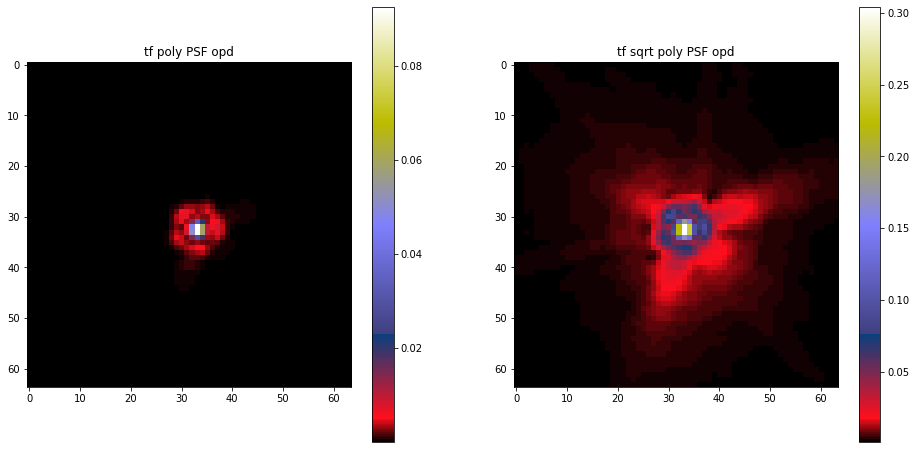

In [ ]:
subplot(121)
imshow(tf_poly_psf_opd, cmap='gist_stern')
colorbar()
title('tf poly PSF opd')

subplot(122)
imshow(np.sqrt(tf_poly_psf_opd), cmap='gist_stern')
title('tf sqrt poly PSF opd')
colorbar()


# Let's try the forward model

In [ ]:
# Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(zernikes, pupil_diameter=real_diam, output_dim=output_dim, LP_filter_length=2, max_order=max_order)
simPSF_np.gen_random_Z_coeffs(max_order=max_order)
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)

np_psf = np.copy(simPSF_np.psf)
target_opd = simPSF_np.opd
target_opd[np.isnan(target_opd)] = 0


# For the polyPSF
packed_elems = generate_packed_elems(PA_SED_wv, simPSF_np, n_bins=20)
max_phase_N = tf.math.reduce_max(packed_elems[0])

obscurations = simPSF_np.generate_pupil_obscurations(N_pix=real_diam, N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex128)

np_opd = simPSF_np.opd
np_opd[np.isnan(np_opd)] = 0
tf_opd = tf.convert_to_tensor(np_opd, dtype=tf.float64)


# Generate the poly-PSF from an OPD

In [ ]:
# Generate from OPD
alt_tf_poly_psf_gen_opd = alt_TF_poly_PSF(tf_obscurations, packed_elems, max_phase_N, output_dim=output_dim)
alt_tf_poly_psf_opd = alt_tf_poly_psf_gen_opd.__call__(tf_opd)

# Generate from OPD
tf_poly_psf_gen_opd = TF_poly_PSF(tf_obscurations, packed_elems, output_dim=output_dim)
tf_poly_psf_opd = tf_poly_psf_gen_opd.__call__(tf_opd)

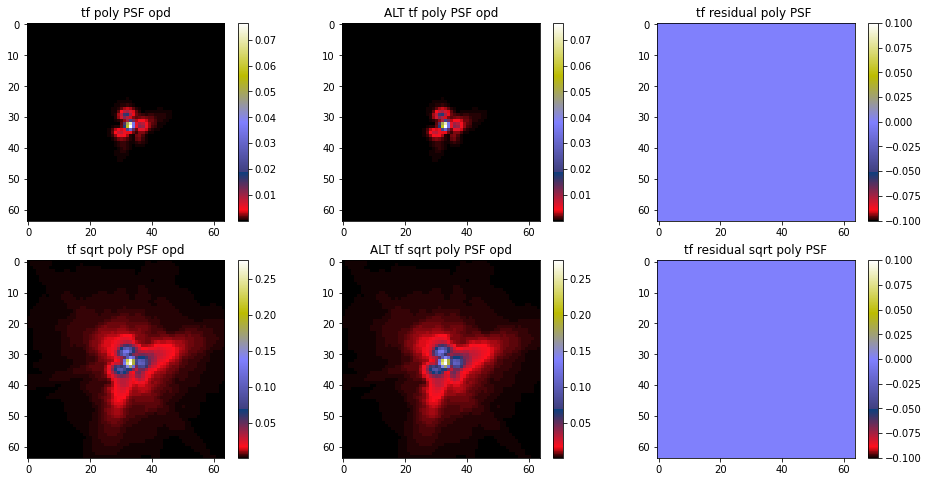

In [ ]:
subplot(231)
imshow(tf_poly_psf_opd, cmap='gist_stern')
colorbar()
title('tf poly PSF opd')

subplot(232)
imshow(alt_tf_poly_psf_opd, cmap='gist_stern')
colorbar()
title('ALT tf poly PSF opd')

subplot(233)
imshow(tf_poly_psf_opd - alt_tf_poly_psf_opd, cmap='gist_stern')
colorbar()
title('tf residual poly PSF ')


subplot(234)
imshow(np.sqrt(tf_poly_psf_opd), cmap='gist_stern')
title('tf sqrt poly PSF opd')
colorbar()

subplot(235)
imshow(np.sqrt(alt_tf_poly_psf_opd), cmap='gist_stern')
title('ALT tf sqrt poly PSF opd')
colorbar()

subplot(236)
imshow(np.sqrt(abs(tf_poly_psf_opd - alt_tf_poly_psf_opd)), cmap='gist_stern')
title('tf residual sqrt poly PSF')
colorbar()

# Generate the poly-PSF from  Zernike coefficients

In [ ]:
# Generate from Zernike coefficients

# Prepare the Zernike coefficients
np_z_coeffs = np.array(z_coeffs)
tf_z_coef = tf.reshape(tf.convert_to_tensor(np_z_coeffs),shape=(np_z_coeffs.shape[0],1,1))

# Initialize the module with required variables
tf_poly_psf_gen_Z = TF_poly_PSF(tf_obscurations, packed_elems, output_dim=output_dim, zernike_maps=tf_zernike_cube)
tf_poly_psf_Z = tf_poly_psf_gen_Z.calculate_from_zernikes(tf_z_coef)

# Initialize the module with required variables
alt_tf_poly_psf_gen_Z = alt_TF_poly_PSF(tf_obscurations, packed_elems,  max_phase_N, output_dim=output_dim, zernike_maps=tf_zernike_cube)
alt_tf_poly_psf_Z = alt_tf_poly_psf_gen_Z.calculate_from_zernikes(tf_z_coef)


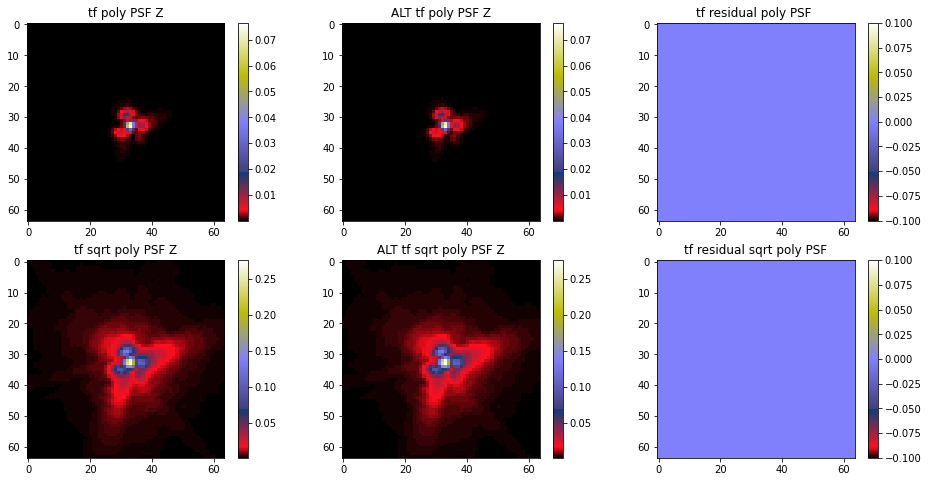

In [ ]:
subplot(231)
imshow(tf_poly_psf_Z, cmap='gist_stern')
colorbar()
title('tf poly PSF Z')

subplot(232)
imshow(alt_tf_poly_psf_Z, cmap='gist_stern')
colorbar()
title('ALT tf poly PSF Z')

subplot(233)
imshow(tf_poly_psf_Z - alt_tf_poly_psf_Z, cmap='gist_stern')
colorbar()
title('tf residual poly PSF ')


subplot(234)
imshow(np.sqrt(tf_poly_psf_Z), cmap='gist_stern')
title('tf sqrt poly PSF Z')
colorbar()

subplot(235)
imshow(np.sqrt(alt_tf_poly_psf_Z), cmap='gist_stern')
title('ALT tf sqrt poly PSF Z')
colorbar()

subplot(236)
imshow(np.sqrt(abs(tf_poly_psf_Z - alt_tf_poly_psf_Z)), cmap='gist_stern')
title('tf residual sqrt poly PSF')
colorbar()


# Let's try to optimize 




In [ ]:
# Let's define the target variables
tf_target_z_coef = tf_z_coef
tf_target_opd = tf_opd
tf_obs_poly_psf = tf_poly_psf_Z


In [ ]:
# Define the initialisation from a set of zernike coefficients

disturbed_z_coef = np.zeros(np_z_coeffs.shape)

init_simPSF_np = SimPSFToolkit(zernikes, pupil_diameter=real_diam, output_dim=output_dim, LP_filter_length=2, max_order=max_order)
init_simPSF_np.set_z_coeffs(disturbed_z_coef.tolist())
init_simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
init_psf = np.copy(init_simPSF_np.psf)
init_opd = init_simPSF_np.opd
init_opd[np.isnan(init_opd)] = 0


tf_disturbed_z_coef = tf.reshape(tf.convert_to_tensor(disturbed_z_coef),shape=(disturbed_z_coef.shape[0],1,1))
tf_init_poly_psf = alt_tf_poly_psf_gen_Z.calculate_from_zernikes(tf_disturbed_z_coef)


Text(0.5, 1.0, 'Residual Z coef')

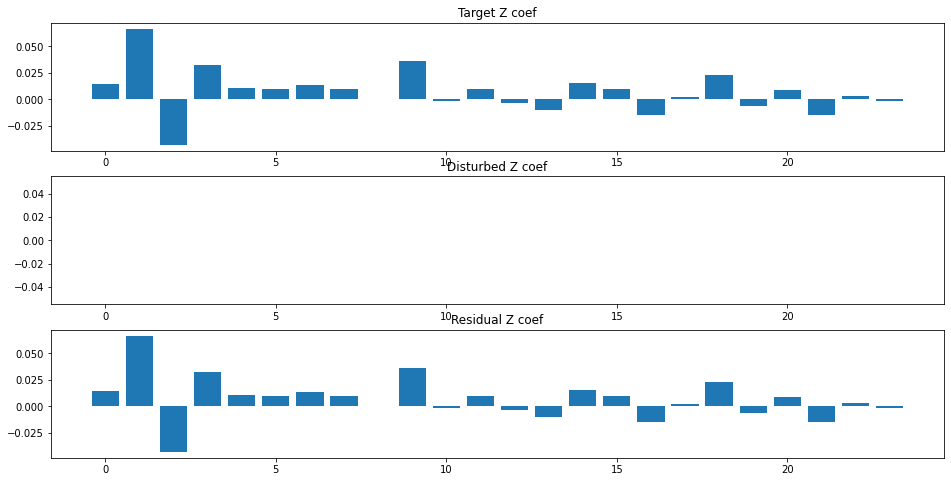

In [ ]:
# Plot the init and target zernike coefficients
subplot(311)
bar(np.arange(np_z_coeffs.shape[0]), np_z_coeffs)
title('Target Z coef')

subplot(312)
bar(np.arange(np_z_coeffs.shape[0]), disturbed_z_coef)
title('Disturbed Z coef')

subplot(313)
bar(np.arange(np_z_coeffs.shape[0]), np_z_coeffs - disturbed_z_coef)
title('Residual Z coef')

Text(0.5, 1.0, 'Target sqrt PSF')

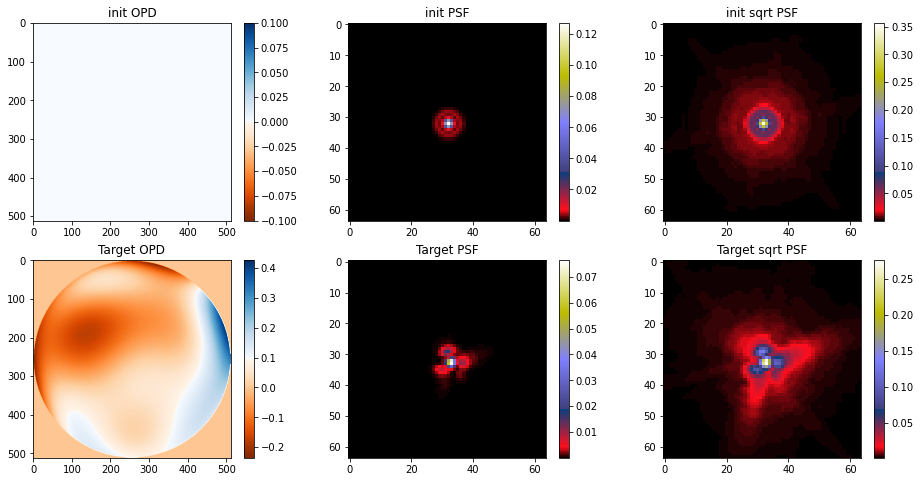

In [ ]:
# Plot the init and target OPDs and PSFs
subplot(231)
imshow(init_opd, cmap=newcmp); colorbar()
title('init OPD')

subplot(232)
imshow(tf_init_poly_psf, cmap='gist_stern'); colorbar()
title('init PSF')

subplot(233)
imshow(np.sqrt(tf_init_poly_psf), cmap='gist_stern')
title('init sqrt PSF')
colorbar()

subplot(234)
imshow(tf_target_opd, cmap=newcmp); colorbar()
title('Target OPD')

subplot(235)
imshow(tf_obs_poly_psf, cmap='gist_stern'); colorbar()
title('Target PSF')

subplot(236)
imshow(np.sqrt(tf_obs_poly_psf), cmap='gist_stern'); colorbar()
title('Target sqrt PSF')


# Unknown model optimisation

In [ ]:
# Define the training variable and the observation
train_opd = tf.Variable(tf.cast(init_opd, tf.float64), trainable=True, dtype=tf.float64, name='train_opd')
lamb = tf.constant(1e-7, dtype=train_opd.dtype)
target_poly_psf = tf.constant(tf.cast(tf_obs_poly_psf, tf.float64), dtype=tf.float64)


In [ ]:
max_phase_N = tf.math.reduce_max(packed_elems[0])
alt_tf_poly_psf_train_gen_opd = alt_TF_poly_PSF(tf_obscurations, packed_elems, max_phase_N, output_dim=64)
# alt_tf_poly_psf_train_gen_opd = TF_poly_PSF(tf_obscurations, packed_elems, output_dim=64)

# @tf.function
def loss_opd():
    
    # Calculate PSF from train_opd  
    data_fidelity = tf.nn.l2_loss(alt_tf_poly_psf_train_gen_opd.__call__(train_opd) - target_poly_psf)
    # regularisation = tf.math.reduce_sum(tf.math.square(train_opd))
    # regularisation = tf.math.reduce_sum(tf.math.abs(train_opd))
    # regularisation = tf.image.total_variation(tf.reshape(train_opd, shape=(1,train_opd.shape[0],train_opd.shape[0],1)))

    # return data_fidelity + lamb * regularisation
    return data_fidelity

loss_opd()

<tf.Tensor: shape=(), dtype=float64, numpy=0.010438473976183985>

0 tf.Tensor(0.008863311103637868, shape=(), dtype=float64)
2 tf.Tensor(0.004804519367035182, shape=(), dtype=float64)
4 tf.Tensor(0.0021602133721691616, shape=(), dtype=float64)
6 tf.Tensor(0.0017374914860125614, shape=(), dtype=float64)
8 tf.Tensor(0.0017327815760604854, shape=(), dtype=float64)
10 tf.Tensor(0.0014902726693554892, shape=(), dtype=float64)
12 tf.Tensor(0.0012328572289160241, shape=(), dtype=float64)
14 tf.Tensor(0.0008724418680105684, shape=(), dtype=float64)
16 tf.Tensor(0.00048815823392490336, shape=(), dtype=float64)
18 tf.Tensor(0.00029427576830757873, shape=(), dtype=float64)
20 tf.Tensor(0.00028588136251906455, shape=(), dtype=float64)
22 tf.Tensor(0.0003116264965064498, shape=(), dtype=float64)
24 tf.Tensor(0.00029093334832528637, shape=(), dtype=float64)
26 tf.Tensor(0.0002429562607334331, shape=(), dtype=float64)
28 tf.Tensor(0.00020687942253113997, shape=(), dtype=float64)
30 tf.Tensor(0.00019264155987136448, shape=(), dtype=float64)
32 tf.Tensor(0.0001873560

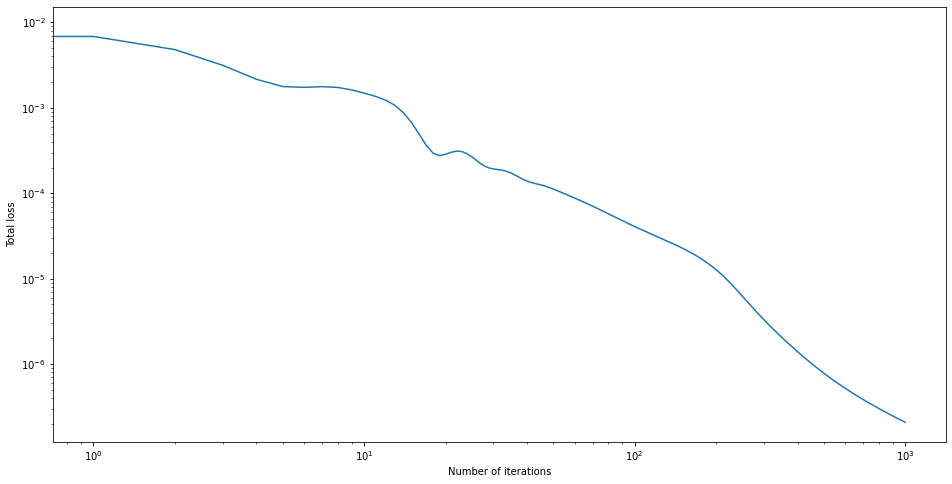

In [ ]:
# Optimization algorithm

optimizer = tf.keras.optimizers.SGD(learning_rate=5e3, momentum=.9, nesterov=True)

n_iter = 1000
verbose = 1
losses = []

for i_iter in tqdm(range(n_iter)):
    
    optimizer.minimize(loss_opd, [train_opd])
    losses.append(loss_opd())
    if verbose > 0 and i_iter % 2 == 0:
        print(i_iter, loss_opd())

loglog(losses)
xlabel('Number of iterations')
ylabel('Total loss');

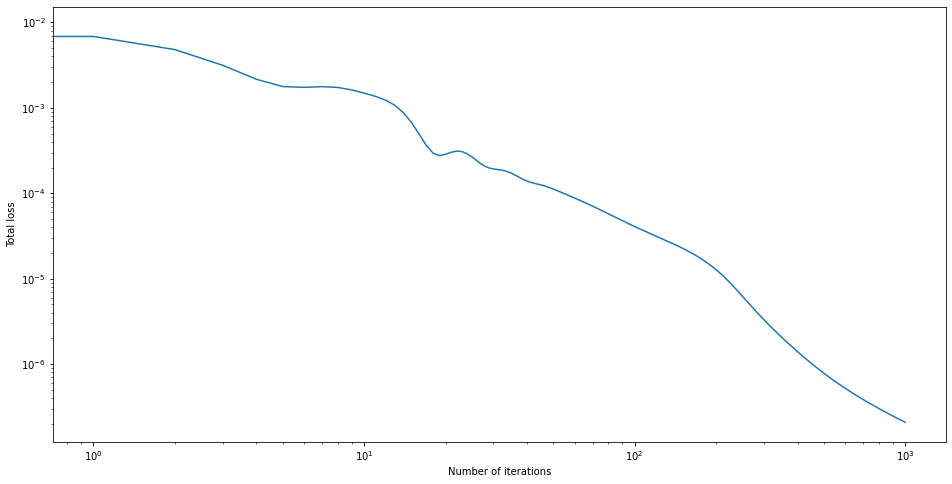

In [ ]:
loglog(losses)
xlabel('Number of iterations')
ylabel('Total loss');

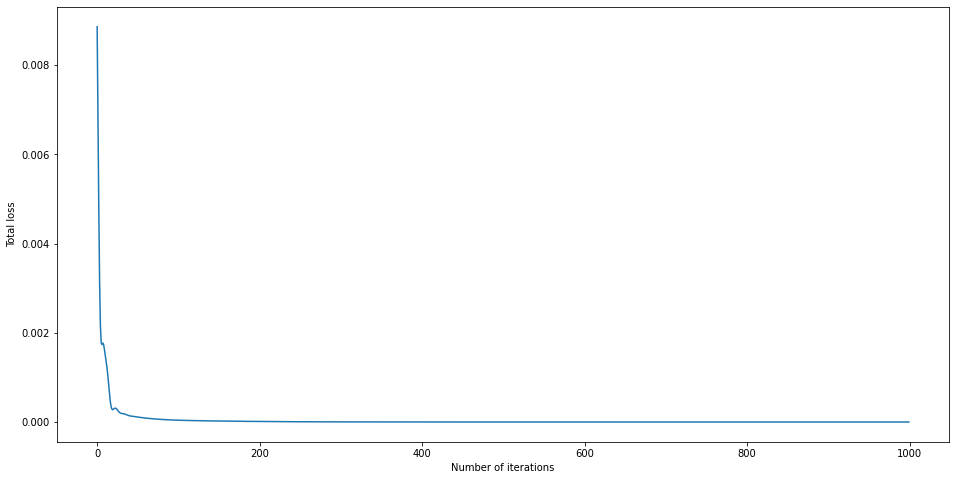

In [ ]:
plot(losses)
xlabel('Number of iterations')
ylabel('Total loss');

Text(0.5, 1.0, 'Init PSF')

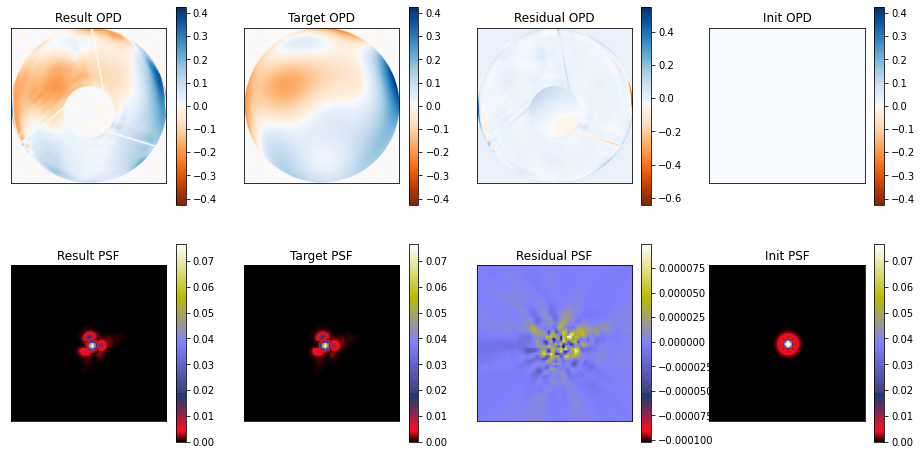

In [ ]:
# Plot results

plot_train_opd = tf.identity(train_opd)

vmax = tf.math.reduce_max([tf.math.abs(plot_train_opd), tf.math.abs(tf_opd)]).numpy()

# Plot the OPD
subplot(241)
imshow(plot_train_opd, cmap=newcmp, vmax=vmax, vmin=-vmax)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Result OPD')

subplot(242)
imshow(tf_target_opd, cmap=newcmp, vmax=vmax, vmin=-vmax)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Target OPD')

subplot(243)
imshow(plot_train_opd - tf_target_opd, cmap=newcmp)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Residual OPD')

subplot(244)
imshow(init_opd, cmap=newcmp, vmax=vmax, vmin=-vmax)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Init OPD')

# result_psf = tf_mono_psf.__call__(plot_train_opd)
result_psf = alt_tf_poly_psf_train_gen_opd.__call__(plot_train_opd)
vmax_psf = tf.math.reduce_max([tf.math.abs(result_psf), tf.math.abs(target_poly_psf)]).numpy()

subplot(245)
imshow(result_psf, cmap='gist_stern', vmax=vmax_psf, vmin=0)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Result PSF')

subplot(246)
imshow(target_poly_psf, cmap='gist_stern', vmax=vmax_psf, vmin=0)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Target PSF')

subplot(247)
imshow(target_poly_psf - result_psf, cmap='gist_stern')
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Residual PSF')

subplot(248)
imshow(tf_init_poly_psf, cmap='gist_stern', vmax=vmax_psf, vmin=0)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Init PSF')



# Now optimize the zernike coefficients

In [ ]:
# Define the optimizing variable
train_z_coeffs = tf.Variable(tf_disturbed_z_coef, trainable=True, dtype=tf.float64, name='train_zernike')
lamb = tf.constant(1e-7, dtype=train_z_coeffs.dtype)

# tf_poly_psf_train_gen_z = TF_poly_PSF(tf_obscurations, packed_elems, output_dim=output_dim, zernike_maps=tf_zernike_cube)
alt_tf_poly_psf_train_gen_opd = alt_TF_poly_PSF(tf_obscurations, packed_elems, max_phase_N, output_dim=output_dim, zernike_maps=tf_zernike_cube)

In [ ]:
# @tf.function
def z_coeff_loss():
    
    # Calculate PSF from train_opd  
    data_fidelity = tf.nn.l2_loss(alt_tf_poly_psf_train_gen_opd.calculate_from_zernikes(train_z_coeffs) - target_poly_psf)
    # regularisation = tf.math.reduce_sum(tf.math.square(train_opd))
    # regularisation = tf.math.reduce_sum(tf.math.abs(train_opd))
    # regularisation = tf.image.total_variation(tf.reshape(train_opd, shape=(1,train_opd.shape[0],train_opd.shape[0],1)))

    # return data_fidelity + lamb * regularisation
    return data_fidelity

z_coeff_loss()

<tf.Tensor: shape=(), dtype=float64, numpy=0.010438473976183985>

In [ ]:
# Optimize 
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=.9, nesterov=True)

n_iter = 1000
verbose = 1
losses = []

for i_iter in tqdm(range(n_iter)):
    
    optimizer.minimize(z_coeff_loss, [train_z_coeffs])
    losses.append(z_coeff_loss())
    if verbose > 0 and i_iter % 2 == 0:
        print(i_iter, z_coeff_loss())

loglog(losses)
xlabel('Number of iterations')
ylabel('Total loss');


0 tf.Tensor(0.004944289722618075, shape=(), dtype=float64)
2 tf.Tensor(0.002007787090800957, shape=(), dtype=float64)
4 tf.Tensor(0.0014417573722307947, shape=(), dtype=float64)
6 tf.Tensor(0.0009068885409815562, shape=(), dtype=float64)
8 tf.Tensor(0.000302263185354017, shape=(), dtype=float64)
10 tf.Tensor(0.0003022460205190367, shape=(), dtype=float64)
12 tf.Tensor(0.00020038346013379155, shape=(), dtype=float64)
14 tf.Tensor(0.00014691473470278453, shape=(), dtype=float64)
16 tf.Tensor(0.00014190960646332345, shape=(), dtype=float64)
18 tf.Tensor(0.0001224989493989387, shape=(), dtype=float64)
20 tf.Tensor(0.00011157204983159703, shape=(), dtype=float64)
22 tf.Tensor(0.00010514601285410691, shape=(), dtype=float64)
24 tf.Tensor(9.864692730258809e-05, shape=(), dtype=float64)
26 tf.Tensor(9.348134072781578e-05, shape=(), dtype=float64)
28 tf.Tensor(8.833083600984419e-05, shape=(), dtype=float64)
30 tf.Tensor(8.366720089626432e-05, shape=(), dtype=float64)
32 tf.Tensor(8.009790766657

KeyboardInterrupt: ignored

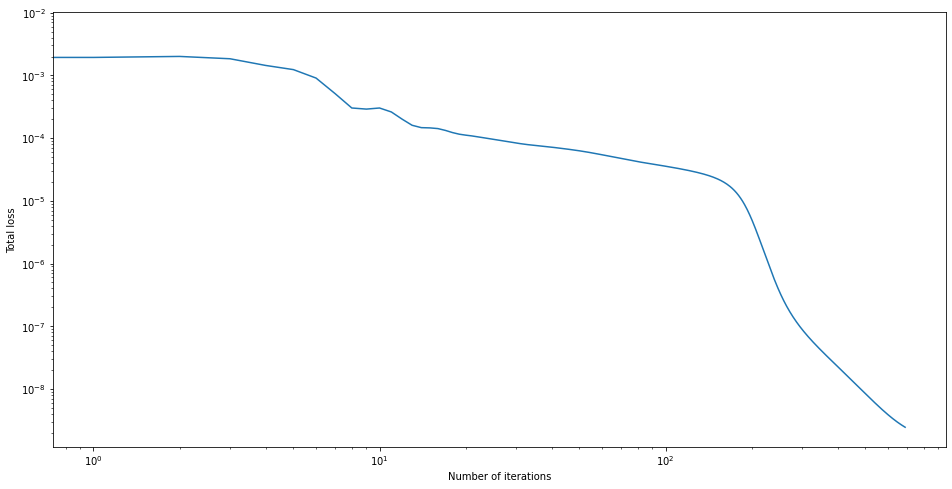

In [ ]:
loglog(losses)
xlabel('Number of iterations')
ylabel('Total loss');

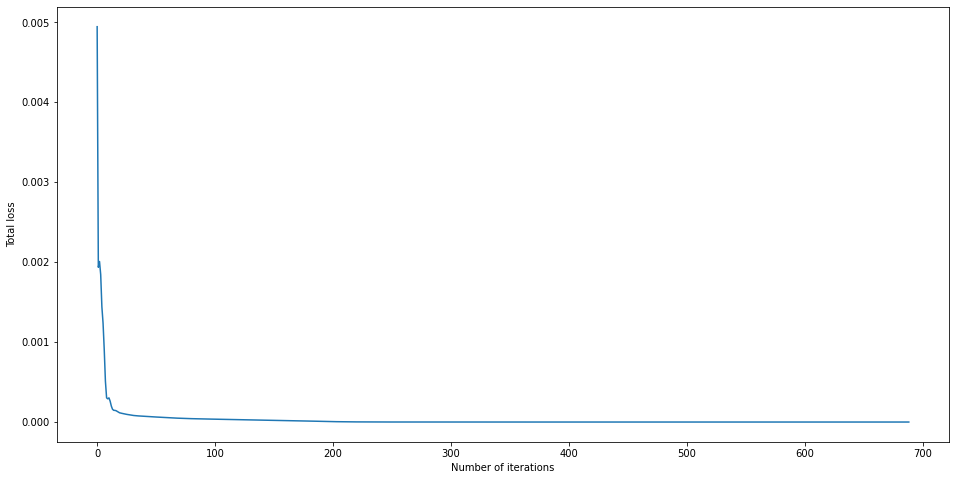

In [ ]:
plot(losses)
xlabel('Number of iterations')
ylabel('Total loss');

Text(0.5, 1.0, 'Init PSF')

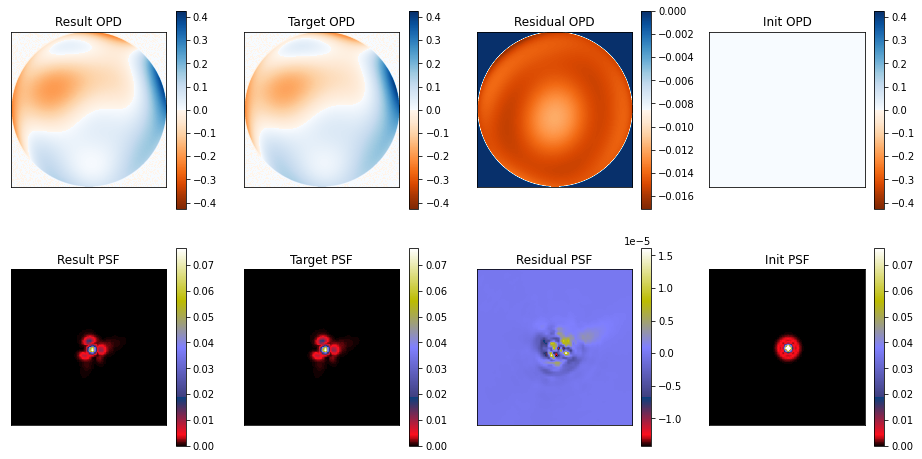

In [ ]:


plot_train_psf = alt_tf_poly_psf_train_gen_opd.calculate_from_zernikes(train_z_coeffs)

tf_zernike_opd_gen = TF_zernike_OPD(tf_zernike_cube)
plot_train_opd = tf_zernike_opd_gen.__call__(train_z_coeffs)

vmax = tf.math.reduce_max([tf.math.abs(plot_train_opd), tf.math.abs(tf_target_opd)]).numpy()

# Plot the OPD
subplot(241)
imshow(plot_train_opd, cmap=newcmp, vmax=vmax, vmin=-vmax)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Result OPD')

subplot(242)
imshow(tf_target_opd, cmap=newcmp, vmax=vmax, vmin=-vmax)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Target OPD')

subplot(243)
imshow(plot_train_opd - tf_target_opd, cmap=newcmp)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Residual OPD')

subplot(244)
imshow(init_opd, cmap=newcmp, vmax=vmax, vmin=-vmax)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Init OPD')


vmax_psf = tf.math.reduce_max([tf.math.abs(plot_train_psf), tf.math.abs(target_poly_psf)]).numpy()

subplot(245)
imshow(plot_train_psf, cmap='gist_stern', vmax=vmax_psf, vmin=0)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Result PSF')

subplot(246)
imshow(target_poly_psf, cmap='gist_stern', vmax=vmax_psf, vmin=0)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Target PSF')

subplot(247)
imshow(target_poly_psf - plot_train_psf, cmap='gist_stern')
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Residual PSF')

subplot(248)
imshow(tf_init_poly_psf, cmap='gist_stern', vmax=vmax_psf, vmin=0)
colorbar()
ax = plt.gca();ax.set_xticks([]);ax.set_yticks([])
title('Init PSF')
